# Alternating Least Squares

References
- https://blog.griddynamics.com/how-deep-learning-improves-recommendations-for-your-catalog/
- https://ethen8181.github.io/machine-learning/recsys/1_ALSWR.html

In [23]:
# %load_ext autoreload # magic so that the notebook will reload external python modules
# %autoreload 2
%config InlineBackend.figure_format = 'retina' # magic to enable retina (high resolution) plots

In [113]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [115]:
from signature import sign

sign(packages="pandas,numpy,sklearn,matplotlib")

Author: Alex Tan Hong Pin

Github username: alextanhongpin

Last updated: 2024-01-26

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.20.0

pandas    : 2.2.0
numpy     : 1.26.3
sklearn   : 1.4.0
matplotlib: 3.8.2

Compiler    : Clang 14.0.0 (clang-1400.0.29.202)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Git hash: c97e2648e53d325730b51c5dba6dbea6191d9390

Git repo: https://github.com/alextanhongpin/matrix-factorization.git

Git branch: master

GPU Info: Install the gpu extra (pip install 'watermark[gpu]') to display GPU information for NVIDIA chipsets

Watermark: 2.4.3



## Loading Data

In [116]:
file_dir = "ml-100k"
file_path = os.path.join(file_dir, "u.data")

names = ["user_id", "item_id", "rating", "timestamp"]
df = pd.read_csv(file_path, sep="\t", names=names)

print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [145]:
# Create the rating matrix, r_ui.
# We substract 1 from the id so that it starts from 0.
n_users = df["user_id"].unique().shape[0]
n_items = df["item_id"].unique().shape[0]
print(n_users, n_items)

943 1682


In [ ]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples(index=False):
    ratings[row.user_id - 1, row.item_id - 1] = row.rating


# Compute the non-zero elements in the matrix.
matrix_size = np.prod(ratings.shape)
interactions = np.flatnonzero(ratings).shape[0]
sparsity = interactions / matrix_size * 100
print(f"dimension: {ratings.shape}")
print(f"sparsity: {sparsity:.1f}%")
ratings

In [118]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size=10, replace=False
        )

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]

    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test


train, test = create_train_test(ratings)
del ratings
train.shape, test.shape

((943, 1682), (943, 1682))

In [119]:
class ExplicitMF:
    def __init__(self, n_iters, n_factors, reg):
        self.n_iters = n_iters
        self.n_factors = n_factors
        self.reg = reg

    def fit(self, train, test):
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))

        self.test_mse_record = []
        self.train_mse_record = []
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(
                train, self.user_factors, self.item_factors
            )
            self.item_factors = self._als_step(
                train.T, self.item_factors, self.user_factors
            )
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)

        return self

    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        A = fixed_vecs.T.dot(fixed_vecs) + self.reg * np.eye(self.n_factors)
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs

    def predict(self):
        pred = self.user_factors.dot(self.item_factors.T)
        return pred

    @staticmethod
    def compute_mse(y_true, y_pred):
        # Ignore zero terms prior to comparing the mse
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [120]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label="Test", linewidth=linewidth)
    plt.plot(model.train_mse_record, label="Train", linewidth=linewidth)
    plt.xlabel("iterations")
    plt.ylabel("MSE")
    plt.legend(loc="best")

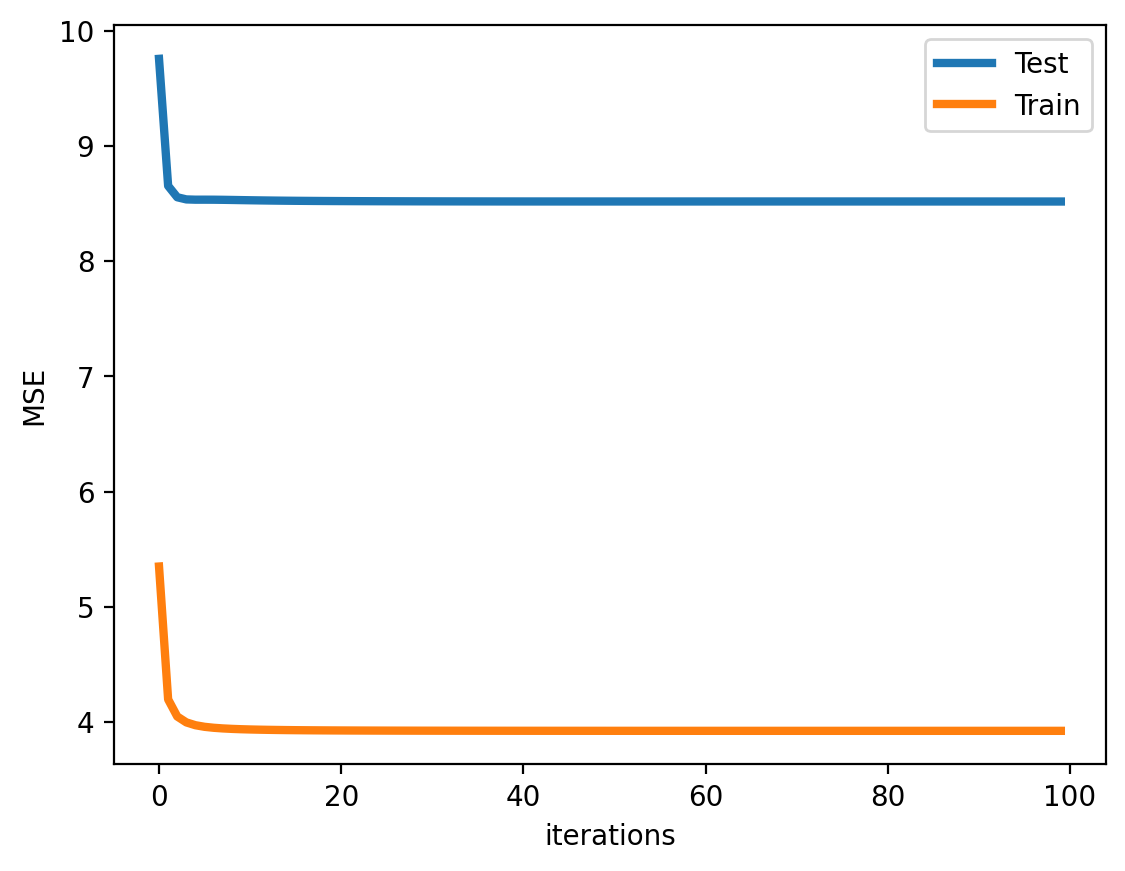

In [122]:
als = ExplicitMF(n_iters=100, n_factors=40, reg=0.01)
als.fit(train, test)
plot_learning_curve(als)

In [177]:
y_pred = als.user_factors[0].dot(als.item_factors.T)

In [187]:
user_data = np.zeros((n_items, 2))

for row in df[df.user_id == 1].itertuples(index=False):
    user_data[row.item_id - 1, 0] = row.rating
    user_data[row.item_id - 1, 1] = y_pred[row.item_id - 1]

pd.DataFrame(user_data, columns=["rating", "predicted"], index=range(n_items)).query(
    "rating > 0"
).sample(20).sort_index()

,rating,predicted
6,4.0,5.315073
35,2.0,0.235685
41,5.0,2.747938
81,5.0,3.076482
89,4.0,1.747228
91,3.0,2.140321
101,2.0,0.759310
104,2.0,0.746177
131,4.0,1.516433
145,4.0,0.740690
